In [ ]:
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ROOT = Path(".").resolve()

ORIG_DIR    = ROOT / "original"
CLAHE_ROOT  = ROOT / "output"
ZERODCE_DIR = ROOT / "Zero-DCE" / "Zero-DCE_code" / "data" / "result" / "dark"

print("ORIG_DIR:", ORIG_DIR, ORIG_DIR.exists())
print("CLAHE_ROOT:", CLAHE_ROOT, CLAHE_ROOT.exists())
print("ZERODCE_DIR:", ZERODCE_DIR, ZERODCE_DIR.exists())


ORIG_DIR: C:\Users\nickd\OneDrive\Desktop\ece253\ECE253\lowlight\original True
CLAHE_ROOT: C:\Users\nickd\OneDrive\Desktop\ece253\ECE253\lowlight\output True
ZERODCE_DIR: C:\Users\nickd\OneDrive\Desktop\ece253\ECE253\lowlight\Zero-DCE-master\Zero-DCE_code\data\result\dark True


In [ ]:
def load_gray(path: Path) -> np.ndarray:
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {path}")
    return img

def resize_to_gray(img: np.ndarray, target_hw: tuple[int, int]) -> np.ndarray:
    h, w = target_hw
    return cv2.resize(img, (w, h), interpolation=cv2.INTER_AREA)

def cdf256(img_gray: np.ndarray) -> np.ndarray:
    # count pixels per intensity
    counts = np.bincount(img_gray.reshape(-1), minlength=256).astype(np.float64)
    cdf = np.cumsum(counts)
    if cdf[-1] == 0:
        return cdf
    return cdf / cdf[-1]

def median_intensity_from_cdf(cdf: np.ndarray) -> int:
    return int(min(np.searchsorted(cdf, 0.5, side="left"), len(cdf) - 1))


In [ ]:
rows = []
skipped = []

case_dirs = sorted([p for p in CLAHE_ROOT.iterdir() if p.is_dir()])

for case_dir in case_dirs:
    case_id = case_dir.name

    p_orig  = ORIG_DIR / f"{case_id}.png"
    p_clahe = case_dir / f"{case_id}_clahe.png"
    p_zero  = ZERODCE_DIR / f"{case_id}.png"

    if not (p_orig.exists() and p_clahe.exists() and p_zero.exists()):
        skipped.append({
            "case": case_id,
            "has_orig": p_orig.exists(),
            "has_clahe": p_clahe.exists(),
            "has_zerodce": p_zero.exists(),
        })
        continue

    rows.append({
        "case": case_id,
        "orig_path": str(p_orig),
        "clahe_path": str(p_clahe),
        "zerodce_path": str(p_zero),
    })

df = pd.DataFrame(rows).sort_values("case").reset_index(drop=True)

print("found:", len(df))
print("skipped :", len(skipped))
df.head()


Matched cases: 45
Skipped cases: 72


,case,orig_path,clahe_path,zerodce_path
0,PB231575,C:\Users\nickd\OneDrive\Desktop\ece253\ECE253\...,C:\Users\nickd\OneDrive\Desktop\ece253\ECE253\...,C:\Users\nickd\OneDrive\Desktop\ece253\ECE253\...
1,PB231582,C:\Users\nickd\OneDrive\Desktop\ece253\ECE253\...,C:\Users\nickd\OneDrive\Desktop\ece253\ECE253\...,C:\Users\nickd\OneDrive\Desktop\ece253\ECE253\...
2,PB231583,C:\Users\nickd\OneDrive\Desktop\ece253\ECE253\...,C:\Users\nickd\OneDrive\Desktop\ece253\ECE253\...,C:\Users\nickd\OneDrive\Desktop\ece253\ECE253\...
3,PB231584,C:\Users\nickd\OneDrive\Desktop\ece253\ECE253\...,C:\Users\nickd\OneDrive\Desktop\ece253\ECE253\...,C:\Users\nickd\OneDrive\Desktop\ece253\ECE253\...
4,PB231585,C:\Users\nickd\OneDrive\Desktop\ece253\ECE253\...,C:\Users\nickd\OneDrive\Desktop\ece253\ECE253\...,C:\Users\nickd\OneDrive\Desktop\ece253\ECE253\...


In [78]:
avg_c_orig  = np.zeros(256, dtype=np.float64)
avg_c_clahe = np.zeros(256, dtype=np.float64)
avg_c_zero  = np.zeros(256, dtype=np.float64)

n = 0

for _, row in df.iterrows():
    orig  = load_gray(Path(row["orig_path"]))
    clahe = load_gray(Path(row["clahe_path"]))
    zero  = load_gray(Path(row["zerodce_path"]))

    h, w = orig.shape[:2]
    if clahe.shape[:2]  != (h, w):  clahe = resize_to_gray(clahe, (h, w))
    if zero.shape[:2]   != (h, w):  zero  = resize_to_gray(zero,  (h, w))

    avg_c_orig  += cdf256(orig)
    avg_c_clahe += cdf256(clahe)
    avg_c_zero  += cdf256(zero)
    n += 1

avg_c_orig  /= n
avg_c_clahe /= n
avg_c_zero  /= n

print("Computed dataset-average CDFs over", n, "images.")


Computed dataset-average CDFs over 45 images.


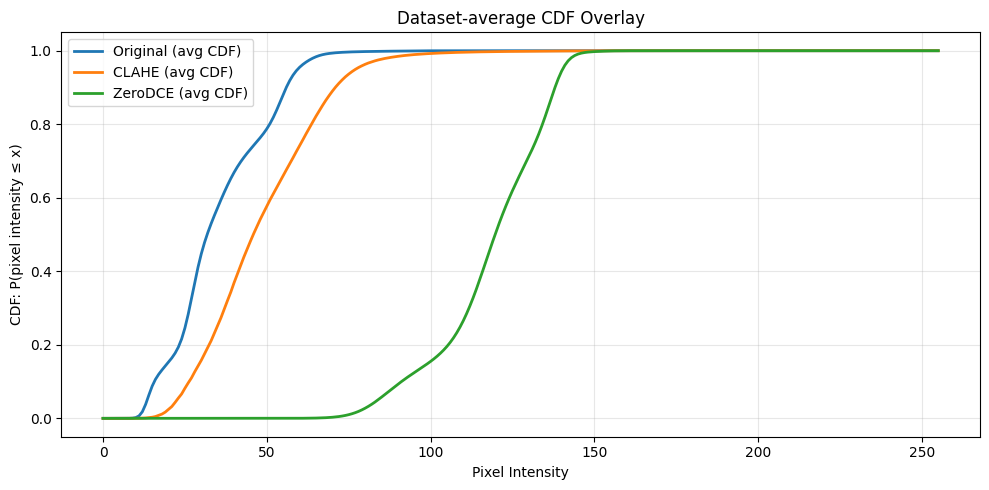

In [79]:
x = np.arange(256)

plt.figure(figsize=(10, 5))
plt.plot(x, avg_c_orig, linewidth=2, label="Original (avg CDF)")
plt.plot(x, avg_c_clahe, linewidth=2, label="CLAHE (avg CDF)")
plt.plot(x, avg_c_zero, linewidth=2, label="ZeroDCE (avg CDF)")
plt.title("Dataset-average CDF Overlay")
plt.xlabel("Pixel Intensity")
plt.ylabel("CDF: P(pixel intensity ≤ x)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
